In [1]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
import pandas as pd
import seaborn as sns
from transformers import BertTokenizer, TFBertModel, BertConfig


c:\Users\AMI_LAB\anaconda3\envs\tensorflow_old\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

In [4]:
df = pd.read_csv("C:/Users/AMI_LAB/Downloads/Lab Work/code/cyberbully classify/dataset_preparation/categorical_data.csv")
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

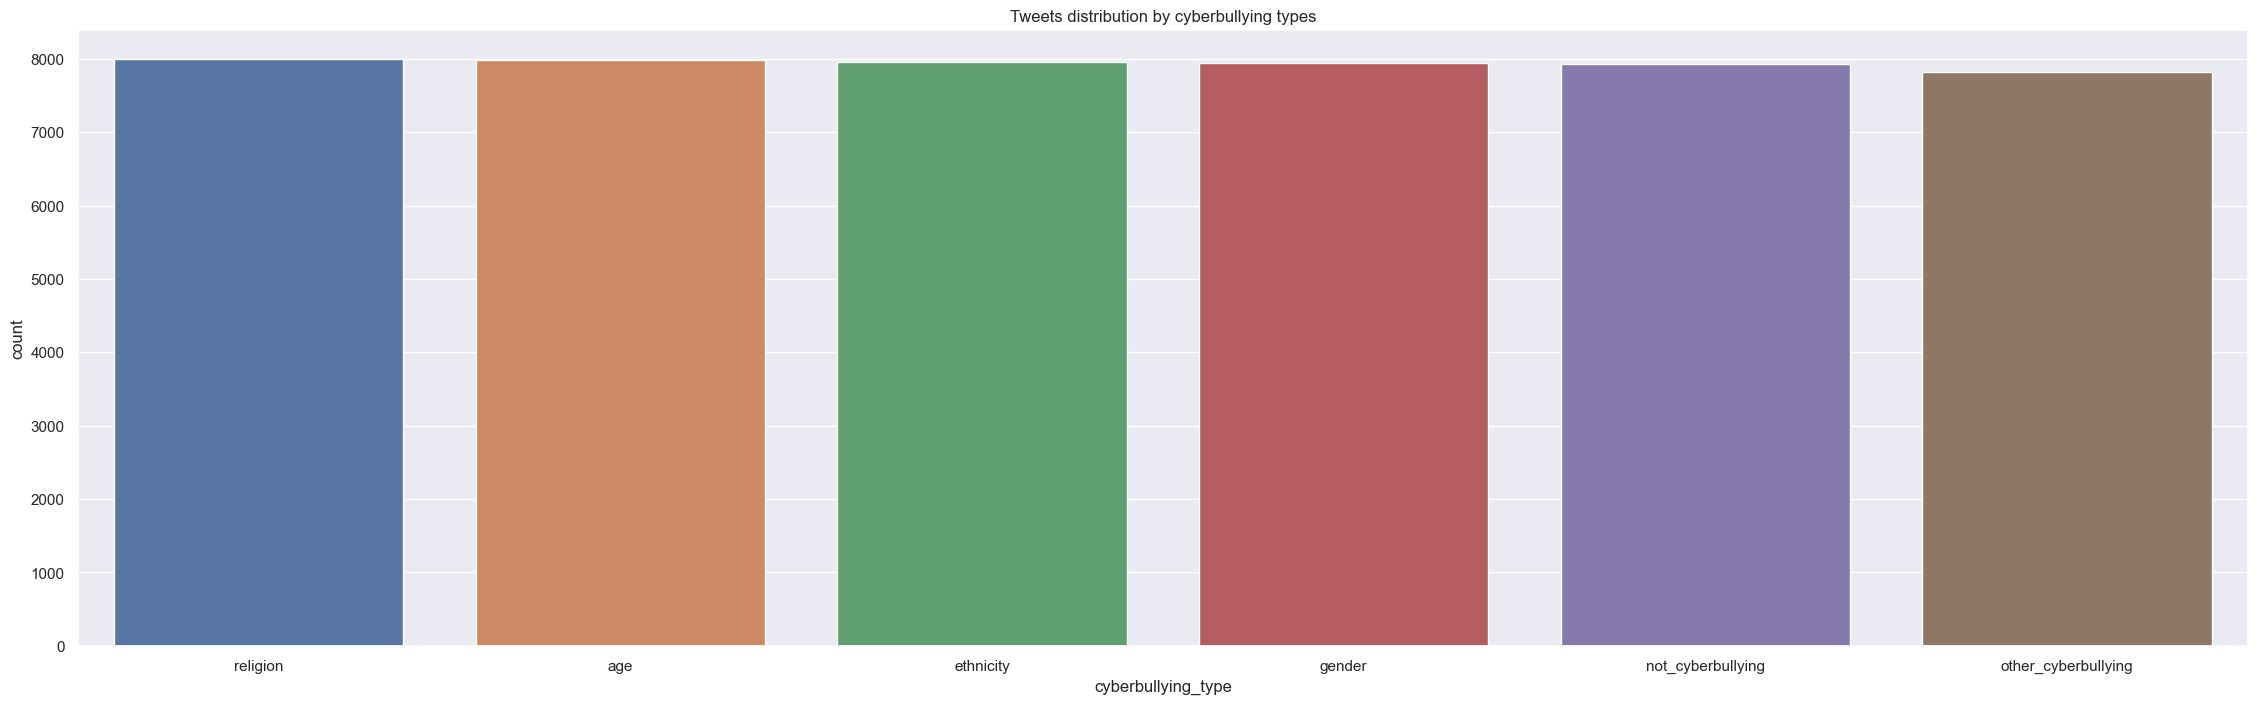

In [5]:
df = df.drop_duplicates()
sns.set(rc={'figure.figsize':(28,8)})
sns.countplot(x="cyberbullying_type", data=df, order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

In [6]:
# classes=list(df["cyberbullying_type"].unique())
# df_list=[]

# flux=700-350
# for i in range(len(classes)):
#     sub_df=df[df["cyberbullying_type"]==classes[i]]
#     #drop first 7000 rows of sub_df
#     if (classes[i]=="other_cyberbullying"):
#         sub_df=sub_df.drop(sub_df.index[:6870+flux])
#     elif (classes[i]=="religion"):
#         sub_df=sub_df.drop(sub_df.index[:7050+flux])
#     elif (classes[i]=="age"):
#         sub_df=sub_df.drop(sub_df.index[:7050+flux])       
#     else:
#         sub_df=sub_df.drop(sub_df.index[:7000+flux])
#     df_list.append(sub_df)


# #concatenate all sub_df
# df_dropped=pd.concat(df_list)
# df_drop=df_dropped.reset_index()


# df = df_drop
# sns.set(rc={'figure.figsize':(28,8)})
# sns.countplot(x="cyberbullying_type", data=df, order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMI_LAB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AMI_LAB\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AMI_LAB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\AMI_LAB\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

def initial_cleaning(text):
    text = re.sub(r"^RT[\s]+","",text)
    text = text.lower()
    text = re.sub(r"https?:\/\/.*[\r\n]*","https",text)
    text = re.sub(r"@[A-Za-z0-9]+","",text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                           "]+", flags=re.UNICODE)

    text=emoji_pattern.sub(r'', text)
    text = re.sub(r'[0-9]',' ',text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    return text

def remove_stopword(text):
    a = [i for i in text.split() if i not in stopwords.words('english')]
    return ' '.join(a)

porter = PorterStemmer()
def stem(text):
    a = [porter.stem(i) for i in text.split()]
    return ' '.join(a)

porter = PorterStemmer()
def stem(text):
    a = [porter.stem(i) for i in text.split()]
    return ' '.join(a)

wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)
def lemmatizer(text):
    word_pos_tags = nltk.pos_tag(tokenizer.tokenize(text))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)



def text_preprocessing(text):
    return lemmatizer(stem(remove_stopword(initial_cleaning(text))))

df["original_tweet"] = df.tweet_text
df.tweet_text = df.tweet_text.apply(lambda x: text_preprocessing(x))
df

c:\Users\AMI_LAB\anaconda3\envs\tensorflow_old\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\AMI_LAB\anaconda3\envs\tensorflow_old\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,tweet_text,cyberbullying_type,original_tweet
0,word katandandr food crapilici mkr,not_cyberbullying,"In other words #katandandre, your food was cra..."
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying,Why is #aussietv so white? #MKR #theblock #ImA...
2,classi whore red velvet cupcak,not_cyberbullying,@XochitlSuckkks a classy whore? Or more red ve...
3,gio meh p thank head concern anoth angri dude ...,not_cyberbullying,"@Jason_Gio meh. :P thanks for the heads up, b..."
4,isi account pretend kurdish account like islam...,not_cyberbullying,@RudhoeEnglish This is an ISIS account pretend...
...,...,...,...
47687,black ppl expect anyth depend anyth yet free p...,ethnicity,"Black ppl aren't expected to do anything, depe..."
47688,turner withhold disappoint turner call court “...,ethnicity,Turner did not withhold his disappointment. Tu...
47689,swear god dumb nigger bitch get bleach hair re...,ethnicity,I swear to God. This dumb nigger bitch. I have...
47690,yea fuck rt your nigger fuck unfollow fuck dum...,ethnicity,Yea fuck you RT @therealexel: IF YOURE A NIGGE...


In [9]:
import imp
from nltk.util import ngrams
from gensim.models import Word2Vec
import multiprocessing
from time import time  # To time our operations
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

text_list_p=df["tweet_text"].tolist()
labels_p=df["cyberbullying_type"].tolist()

text_list=[]
labels=[]
for i in range(len(labels_p)):
    if text_list_p[i]!='':
        text_list.append(text_list_p[i])
        labels.append(labels_p[i])

labels=np.array(labels)


label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
num_classes=int(np.max(integer_encoded)+1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
mapping = dict(zip(label_encoder.classes_, onehot_encoder.transform(label_encoder.transform(label_encoder.classes_).reshape(num_classes, 1))))
for key,value in mapping.items():
    print("",key," ----------------------------- ",value)




omega_text_words = []
n=1
cores = multiprocessing.cpu_count() # Count the number of cores in a computer


for i in range(len(text_list)):
    sentence=text_list[i]
    unigrams = ngrams(sentence.split(), n)
    flat_list = [item for sublist in [list(a) for a in unigrams] for item in sublist]
    omega_text_words.append(flat_list)

c:\Users\AMI_LAB\anaconda3\envs\tensorflow_old\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  """Entry point for launching an IPython kernel.


 age  -----------------------------  [1. 0. 0. 0. 0. 0.]
 ethnicity  -----------------------------  [0. 1. 0. 0. 0. 0.]
 gender  -----------------------------  [0. 0. 1. 0. 0. 0.]
 not_cyberbullying  -----------------------------  [0. 0. 0. 1. 0. 0.]
 other_cyberbullying  -----------------------------  [0. 0. 0. 0. 1. 0.]
 religion  -----------------------------  [0. 0. 0. 0. 0. 1.]


In [10]:
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
#shuffler
def unison_shuffled_copies(a, b,c):
    assert len(a) == len(b==len(c))
    p = np.random.permutation(len(a))
    return a[p], b[p],c[p]


t=Tokenizer()
t.fit_on_texts(text_list)
vocab_size = len(t.word_index) + 1
X_encoded= t.texts_to_sequences(text_list)
max_len=max(len(l) for l in X_encoded)


Y=tf.keras.utils.to_categorical(integer_encoded, num_classes=6)

tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
X_bert = [tokenizer_bert(text, padding='max_length', max_length = max_len, truncation=True)['input_ids'] for text in text_list]
X_bert = np.array(X_bert, dtype='int32')
Mask_bert= [tokenizer_bert(text, padding='max_length', max_length = max_len, truncation=True)['attention_mask'] for text in text_list]
Mask_bert = np.array(Mask_bert, dtype='int32')
X=X_bert
Z=Mask_bert





X,Y,Z=unison_shuffled_copies(X, Y,Z)


# Split the dataset
val_split_percent=0.2
test_split_percent=0.1
split_train = int(len(X)*(1-val_split_percent-test_split_percent))
split_valid = int(len(X)*(1-test_split_percent))

# Train
X_train = X[:split_train, :]; y_train=Y[:split_train, :]; z_train=Z[:split_train, :]

# Valid
X_valid = X[split_train:split_valid,:]; y_valid=Y[split_train:split_valid,:]; z_valid=Z[split_train:split_valid,:]

# Test
X_test = X[split_valid:,:]; y_test=Y[split_valid:,:]; z_test=Z[split_valid:,:]

   
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(33281, 413) (33281, 6)
(9509, 413) (9509, 6)
(4755, 413) (4755, 6)


In [12]:
config = BertConfig(dropout=0.2, attention_dropout=0.2)
dbert = TFBertModel.from_pretrained("bert-base-uncased", config=config, trainable=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
from tensorflow.keras import models

input_ids_in = layers.Input(shape=(max_len,), name='input_token', dtype='int32')
masks= layers.Input(shape = (max_len,), dtype='int32')
x = dbert(input_ids=input_ids_in,attention_mask=masks)[0][:,0,:]
x= layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(x)
x= layers.Dropout(0.5)(x)
x= layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(x)
x= layers.Dropout(0.5)(x)
x = layers.Dense(6, activation='softmax', name='classification')(x)

dmodel = models.Model(inputs=[input_ids_in,masks], outputs = x)

dmodel.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='categorical_crossentropy', metrics=['accuracy'])
dmodel.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 413)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 413)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'input_1[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 413,                                           

In [14]:
history = dmodel.fit([X_train,z_train], y_train, batch_size=64, shuffle=True, epochs=50, validation_data=([X_valid,z_valid], y_valid))

Epoch 1/50
521/521 [==============================] - 346s 647ms/step - loss: 2.2420 - accuracy: 0.6069 - val_loss: 1.0486 - val_accuracy: 0.7108
Epoch 2/50
521/521 [==============================] - 336s 646ms/step - loss: 1.1605 - accuracy: 0.6605 - val_loss: 0.9843 - val_accuracy: 0.7173
Epoch 3/50
521/521 [==============================] - 336s 646ms/step - loss: 1.1081 - accuracy: 0.6612 - val_loss: 0.9599 - val_accuracy: 0.7158
Epoch 4/50
474/521 [==========================>...] - ETA: 24s - loss: 1.0904 - accuracy: 0.6656

KeyboardInterrupt: 

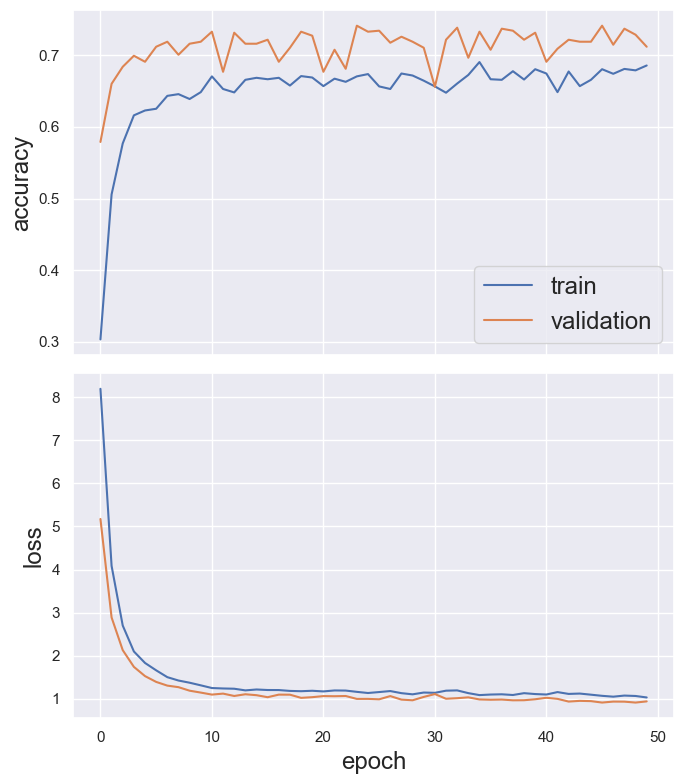

In [ ]:
import stellargraph as sg
sg.utils.plot_history(history)



In [ ]:
# save val_loss, val_acc, loss, acc as csv with headers
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

# save val_loss, val_acc, loss, acc as csv with headers
import pandas as pd
df = pd.DataFrame({'val_loss':val_loss, 'val_acc':val_acc, 'loss':loss, 'acc':acc})
df.to_csv('bert_mlp.csv', index=False)

In [ ]:
_, acc = dmodel.evaluate([X_test,z_test], y_test)
print("Accuracy = ", (acc * 100.0), "%")

12/12 [==============================] - 1s 67ms/step - loss: 0.9417 - accuracy: 0.7207
Accuracy =  72.06704020500183 %


12/12 [==============================] - 3s 67ms/step


<AxesSubplot:>

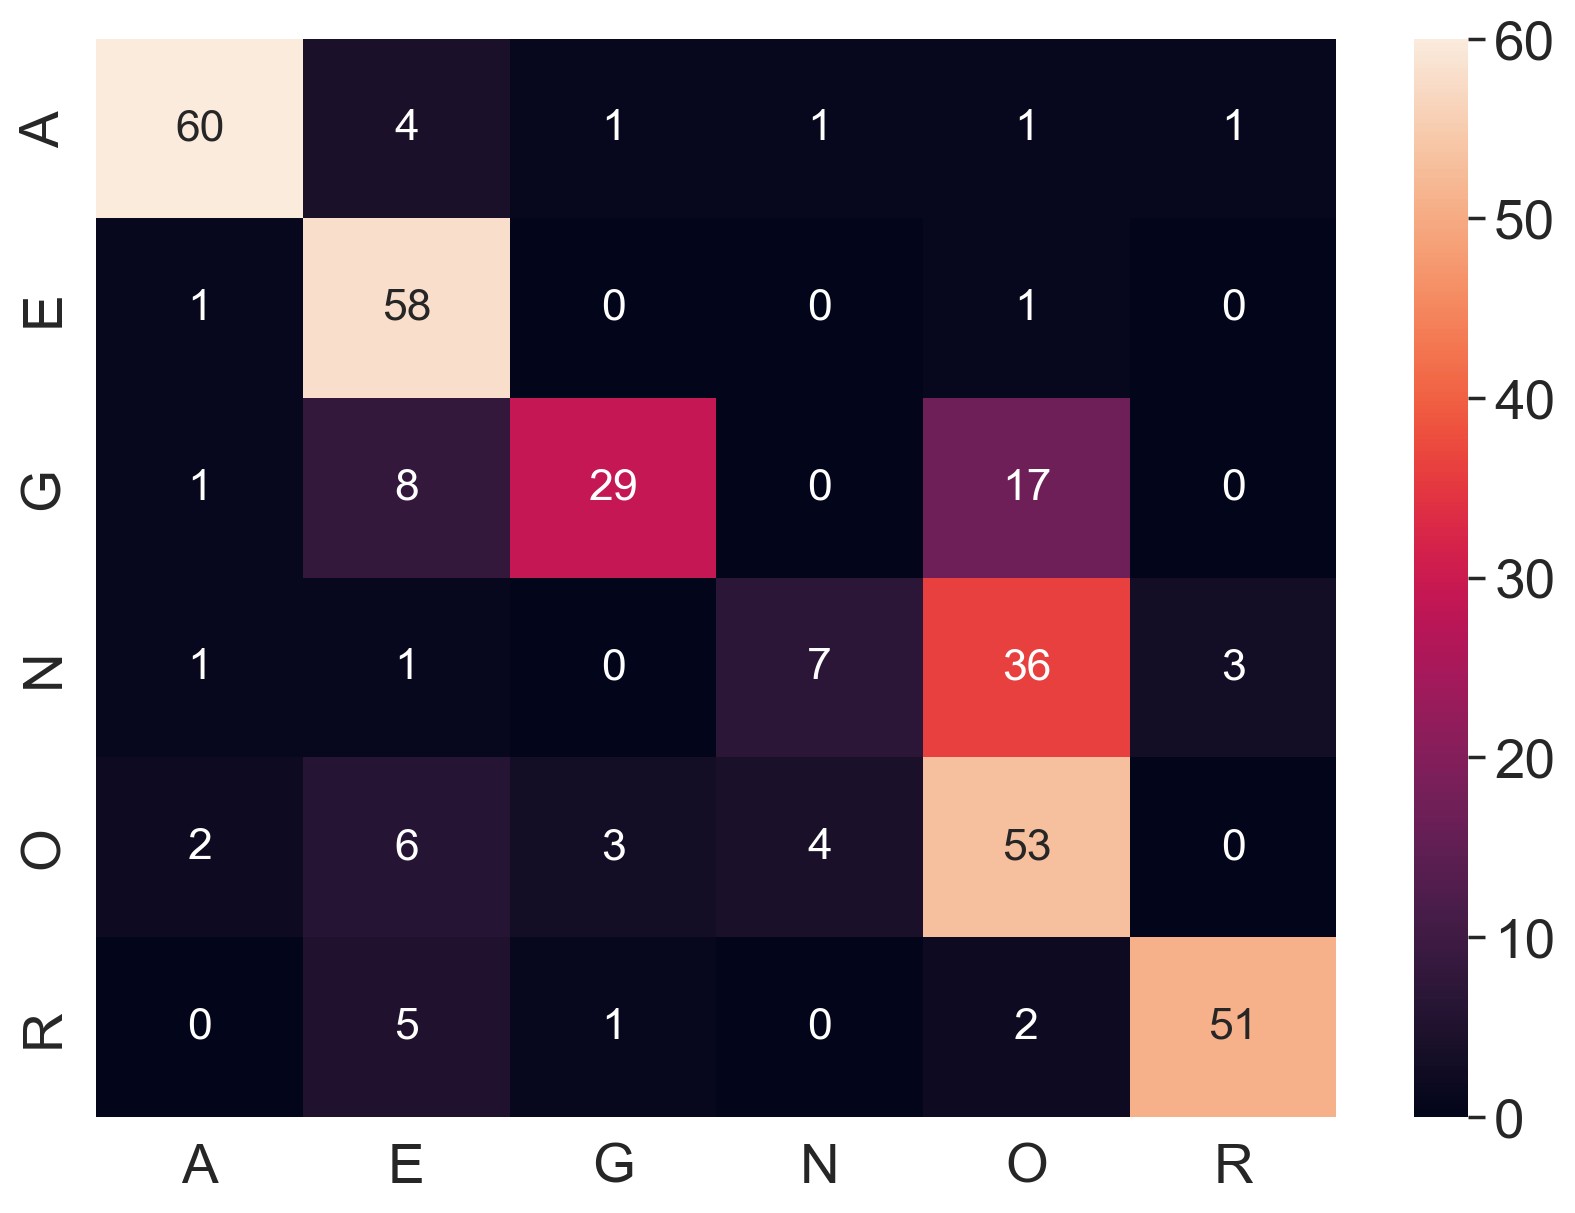

In [ ]:
ref=np.argmax(y_test,axis=1)
predictions=np.argmax(dmodel.predict([X_test,z_test]),axis=1)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ref,predictions)



label_names=[]
for key,_ in mapping.items():
    label_names.append(key)

label_abbreviations = [label[0].upper() for label in label_names]


#plot confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, label_abbreviations, label_abbreviations)
plt.figure(figsize = (10,7),dpi=200)
sn.set(font_scale=1.8)  # Increase the font size for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d') # font size

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ref, predictions,digits=4))

              precision    recall  f1-score   support

           0     0.9231    0.8824    0.9023        68
           1     0.7073    0.9667    0.8169        60
           2     0.8529    0.5273    0.6517        55
           3     0.5833    0.1458    0.2333        48
           4     0.4818    0.7794    0.5955        68
           5     0.9273    0.8644    0.8947        59

    accuracy                         0.7207       358
   macro avg     0.7460    0.6943    0.6824       358
weighted avg     0.7475    0.7207    0.7003       358

